# Predicting Dengue
#### <div style="text-align: right"> Viktor Chee and Chad Ikeda </div>

We will now embark on using multiple machine methods in attempt to predict dengue. 

 (1) [**Data Preperation**](#data-prep)

This will have several components including **preparing the data**, by loading the data into an appropriate structure, wrangling the data as needed for analysis / visualization, dealing with missing values, and normalizing the data to a common scale (for analysis). Most of the prep work is similar and was done in our previous analysis which can be [found here](https://info370a-au18.github.io/a3-cheekw/).

 (2) [**Feature Engineering and Selection**](#feature-select)

Create at least one new feature (column) based on your domain knowledge. Using a learning based approach to incorporate **feature selection** into the modeling. We have decided to split the data into subtrain and subtest sets at the end of this section rather then in data preperation section because introducing too many data sets makes it difficult to work with when creating new features or performing feature selection.

 (3) [**Modeling**](#modeling)

Use 4 algorithms of **modeling**, appropriately using testing and training data, pre-processing the data using a scaler (if necessary), performing cross validation and optimizing the parameters of the model using a grid-search.


 (4) [**Validation and Visualizations**](#data-vis)

Finally composing atleast 3 **data visualizations** comparing the accuracy across the models, comparing the predictions to the data (for each model), assessing the performance for different parameters.

<a id='data-prep'></a>
## Data Preperation

We will start by loading and looking at the data that we have from the [DengAI challenge](https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/page/82/). From the previous assignment, we decided that the best way to deal with null values was to do a forward-fill. This is possible because the data is sorted chronologically by time. It provides smoother results rather than imputing by mean or median, allowing for an estimate of the seasonal trend at the time of the missing values.

In [1]:
# importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

# for making the report cleaner
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
# getting the data
filepath = 'data/'
dengue_train_features = pd.read_csv(filepath + 'dengue_features_train.csv')
dengue_test_features = pd.read_csv(filepath + 'dengue_features_test.csv')
dengue_train_labels = pd.read_csv(filepath + 'dengue_labels_train.csv')
dengue_train_features['total_cases'] = dengue_train_labels.total_cases

Check the null values:

In [3]:
# number of null values per column
print('NA values for train')
dengue_train_features.isna().sum()

NA values for train


city                                       0
year                                       0
weekofyear                                 0
week_start_date                            0
ndvi_ne                                  194
ndvi_nw                                   52
ndvi_se                                   22
ndvi_sw                                   22
precipitation_amt_mm                      13
reanalysis_air_temp_k                     10
reanalysis_avg_temp_k                     10
reanalysis_dew_point_temp_k               10
reanalysis_max_air_temp_k                 10
reanalysis_min_air_temp_k                 10
reanalysis_precip_amt_kg_per_m2           10
reanalysis_relative_humidity_percent      10
reanalysis_sat_precip_amt_mm              13
reanalysis_specific_humidity_g_per_kg     10
reanalysis_tdtr_k                         10
station_avg_temp_c                        43
station_diur_temp_rng_c                   43
station_max_temp_c                        20
station_mi

In [4]:
# number of null values per column
print('NA values for test')
dengue_test_features.isna().sum()

NA values for test


city                                      0
year                                      0
weekofyear                                0
week_start_date                           0
ndvi_ne                                  43
ndvi_nw                                  11
ndvi_se                                   1
ndvi_sw                                   1
precipitation_amt_mm                      2
reanalysis_air_temp_k                     2
reanalysis_avg_temp_k                     2
reanalysis_dew_point_temp_k               2
reanalysis_max_air_temp_k                 2
reanalysis_min_air_temp_k                 2
reanalysis_precip_amt_kg_per_m2           2
reanalysis_relative_humidity_percent      2
reanalysis_sat_precip_amt_mm              2
reanalysis_specific_humidity_g_per_kg     2
reanalysis_tdtr_k                         2
station_avg_temp_c                       12
station_diur_temp_rng_c                  12
station_max_temp_c                        3
station_min_temp_c              

In [5]:
# forward filling data
dengue_train_features.fillna(method='ffill', inplace=True)
dengue_test_features.fillna(method='ffill', inplace=True)

In our exploratory data analysis, we found that splitting the data by city was the best way to differentiate the climate conditions that predicts the dengue virus. We will now split the data. We will also drop `ndvi_ne` due to too many missing values. `ffill` doesn't perform the best when there are many missing values consecutively.

In [6]:
# dropping column with most missing values
dengue_train_features = dengue_train_features.drop('ndvi_ne', axis=1)
dengue_test_features = dengue_test_features.drop('ndvi_ne', axis=1)

In [7]:
# seperating train features by city
sj_train_features = dengue_train_features[dengue_train_features['city']=='sj']
iq_train_features = dengue_train_features[dengue_train_features['city']=='iq']

# seperating train labels by city
sj_train_labels = dengue_train_labels[dengue_train_labels['city']=='sj']
iq_train_labels = dengue_train_labels[dengue_train_labels['city']=='iq']

# serperating test features by city
sj_test_features = dengue_test_features[dengue_test_features['city']=='sj']
iq_test_features = dengue_test_features[dengue_test_features['city']=='iq']

In [8]:
# dropping the city columns
sj_train_features = sj_train_features.drop('city', axis=1)
iq_train_features = iq_train_features.drop('city', axis=1)

sj_train_labels = sj_train_labels.drop('city', axis=1)
iq_train_labels = iq_train_labels.drop('city', axis=1)

sj_test_features = sj_test_features.drop('city', axis=1)
iq_test_features = iq_test_features.drop('city', axis=1)

In [9]:
print('sj train shape', sj_train_features.shape)
print('iq train shape', iq_train_features.shape)

sj train shape (936, 23)
iq train shape (520, 23)


Most of the feature analysis was already performed in the previous assignment. We can reconfirm by looking at the correlations and distributions of the data again before we dive into make a plan for experimenting on what we want to do with the features.

Text(0.5, 1.0, 'Heatmap for Iquitos')

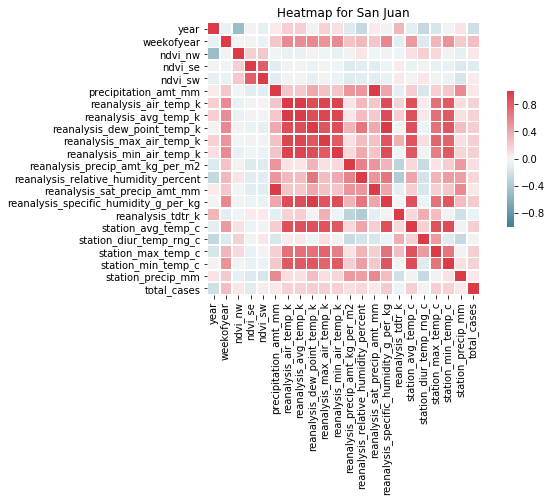

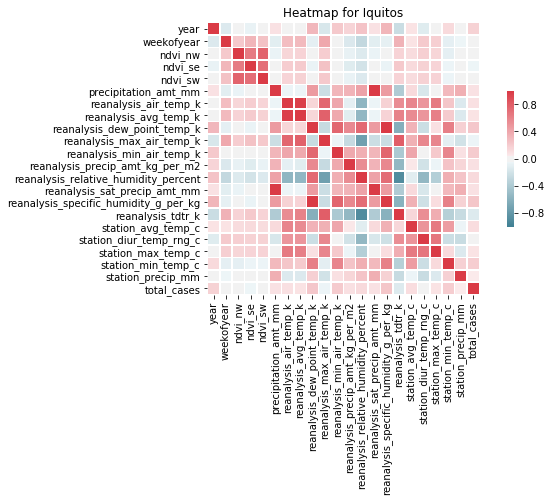

In [10]:
# getting correlations
sj_corr = sj_train_features.corr()
iq_corr = iq_train_features.corr()

# correlations matrix for San Juan
plt.figure(figsize=(10,5))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(sj_corr, cmap=cmap, vmax=1, vmin=-1, center=0,
         square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Heatmap for San Juan')


# correlations matrix for Iquitos
plt.figure(figsize=(10,5))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(iq_corr, cmap=cmap, vmax=1, vmin=-1, center=0,
         square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Heatmap for Iquitos')

SJ train feature distribution


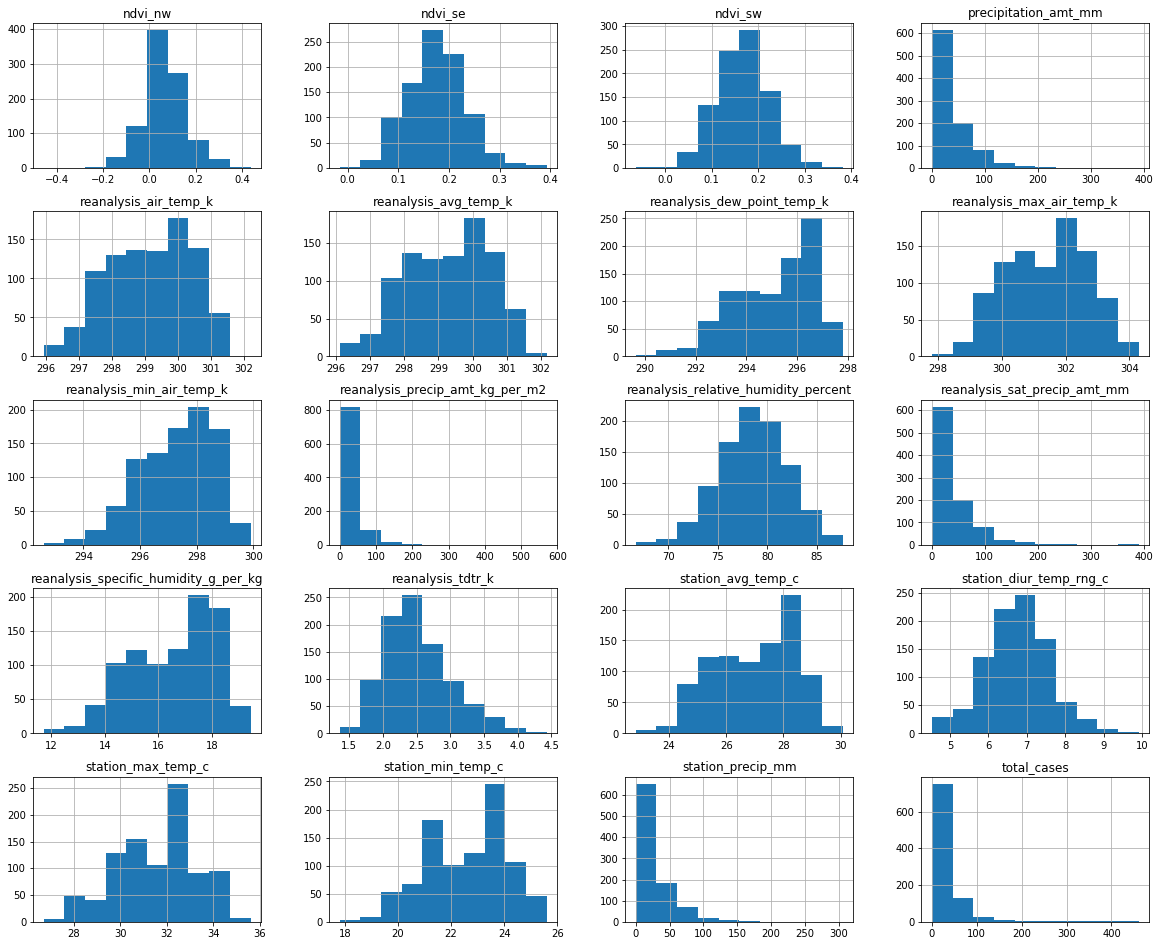

In [11]:
# plotting histograms
non_numeric = ['year','week_start_date', 'weekofyear']
print('SJ train feature distribution')
sj_train_features.drop(non_numeric, axis=1).hist(layout=(6,4), figsize=(20,20));

IQ train feature distribution


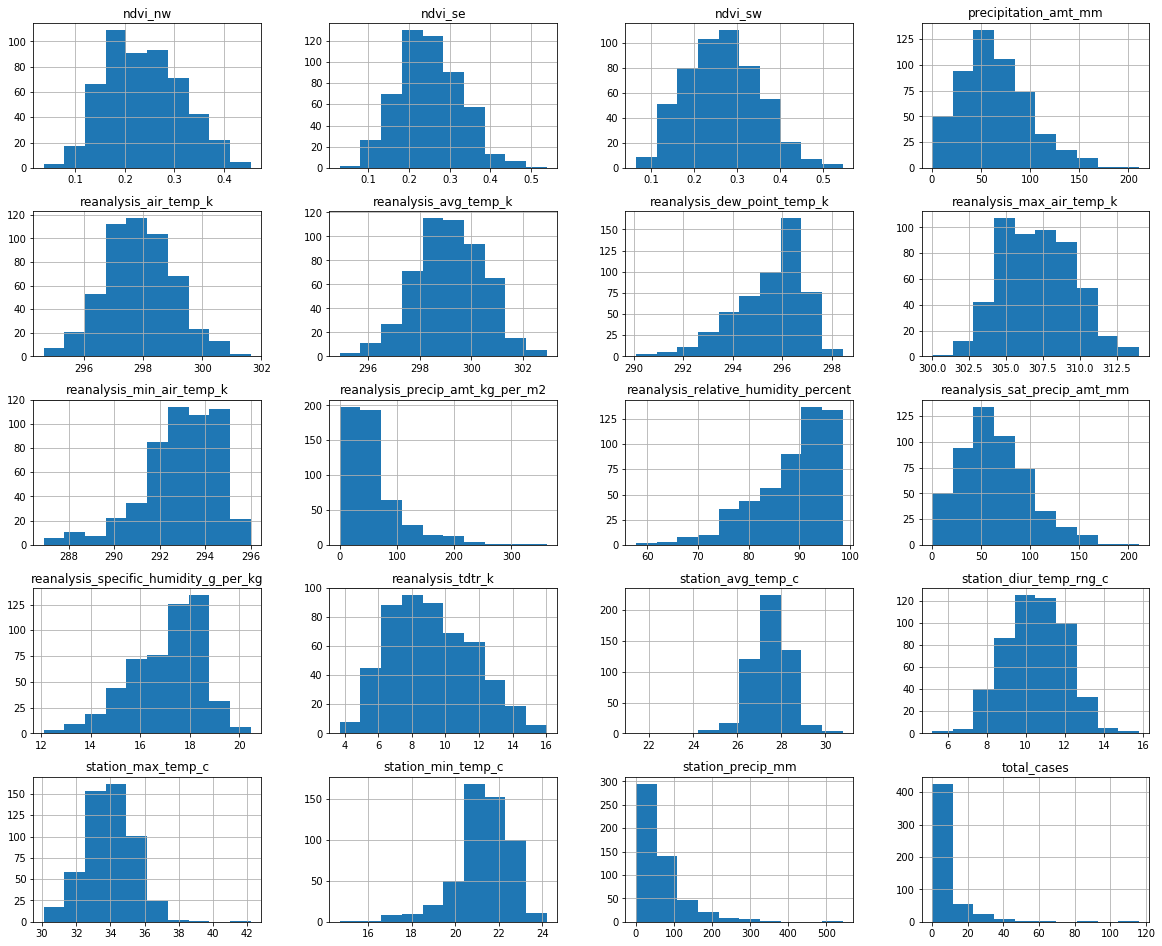

In [12]:
print('IQ train feature distribution')
iq_train_features.drop(non_numeric, axis=1).hist(layout=(6,4), figsize=(20,20));

As noted from our previous analysis, we see that we have a lot of features that don't follow a normal distribution. We also found that the variance for the total cases was far greater than the mean.

<a id='feature-select'></a>
## Feature Engineering and Selection
We will now engage in an attempt to choose the features to use for the data.

 One such method is to simply look at the most correlated values to `total_cases` and use those for our features of interest. This can be done using Recursive Feature Selection, with a linear kernel.

In [13]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVR

In [14]:
# returns the top 5 features in terms of correlation 
def rfe(train_features):
    not_checking = ['year', 'weekofyear', 'week_start_date']
    train = train_features.drop(not_checking, axis=1)
    X = train.loc[:,train.columns!='total_cases']
    y = train['total_cases']
    estimator = SVR(kernel="linear")
    selector = RFE(estimator, 5, step=1)
    selector = selector.fit(X, y)

    ranking = selector.ranking_
    columns = X.columns.values
    for i in range(len(ranking)):
        print(ranking[i], columns[i])
    return columns[selector.support_]

In [15]:
# selecting for sj
print('sj feature ranks')
sj_rfe_support = rfe(sj_train_features)

sj feature ranks
1 ndvi_nw
7 ndvi_se
8 ndvi_sw
13 precipitation_amt_mm
10 reanalysis_air_temp_k
2 reanalysis_avg_temp_k
1 reanalysis_dew_point_temp_k
1 reanalysis_max_air_temp_k
5 reanalysis_min_air_temp_k
12 reanalysis_precip_amt_kg_per_m2
11 reanalysis_relative_humidity_percent
15 reanalysis_sat_precip_amt_mm
1 reanalysis_specific_humidity_g_per_kg
1 reanalysis_tdtr_k
3 station_avg_temp_c
4 station_diur_temp_rng_c
9 station_max_temp_c
6 station_min_temp_c
14 station_precip_mm


In [16]:
# selecting for iq
print('iq feature ranks')
iq_rfe_support = rfe(iq_train_features)

iq feature ranks
4 ndvi_nw
1 ndvi_se
2 ndvi_sw
13 precipitation_amt_mm
5 reanalysis_air_temp_k
1 reanalysis_avg_temp_k
1 reanalysis_dew_point_temp_k
1 reanalysis_max_air_temp_k
3 reanalysis_min_air_temp_k
14 reanalysis_precip_amt_kg_per_m2
6 reanalysis_relative_humidity_percent
15 reanalysis_sat_precip_amt_mm
1 reanalysis_specific_humidity_g_per_kg
7 reanalysis_tdtr_k
11 station_avg_temp_c
10 station_diur_temp_rng_c
9 station_max_temp_c
8 station_min_temp_c
12 station_precip_mm


Previously we had actually already tested out RFE in our model predictions. When used they produced suboptimal results so we based our feature choices off of the research we did rather than a feature selection technique. We will not be including the attempts we did for RFE in our report because training the ML models takes much longer than expected.

We will try to test out how the models perform on some features that we think are important. We chose station `temp` measurements because we believe land station measurements they would be more accurate than a satelite for measurements such as temperature. For other information such as `precip`, we found that a satelite would perform better. Our previous research results showed that the following features would be important for the survivability of the dengue virus vectors:

In [17]:
climate_columns = ['reanalysis_dew_point_temp_k',
                   'reanalysis_precip_amt_kg_per_m2',
                   'reanalysis_specific_humidity_g_per_kg',
                   'station_avg_temp_c', 
                   'station_max_temp_c',
                   'station_min_temp_c']
climate_columns

['reanalysis_dew_point_temp_k',
 'reanalysis_precip_amt_kg_per_m2',
 'reanalysis_specific_humidity_g_per_kg',
 'station_avg_temp_c',
 'station_max_temp_c',
 'station_min_temp_c']

We also decided to create a rolling average which may be able to account for any sort of movement in the temperature and weather data. We found many studies to be using an autoregressive time series ARIMA or SARIMA method for accurately predicting malaria, zika and dengue. Due to the seasonal fluctuations, the algorithms we think that the rolling mean can help fully capture patterns that occur for climate conditions over the longer term. In choosing the window, we went with every year '52 weeks' as that follows the general trend of the temperature fluctuations and climate condition changes that we saw from previous analysis.

In [35]:
# adds rolling features
def add_roll_features(df, window):
    mean_columns = ['reanalysis_dew_point_temp_k',
                    'reanalysis_specific_humidity_g_per_kg',
                    'station_avg_temp_c', 
                    'station_max_temp_c',
                    'station_min_temp_c']
    sum_columns = ['reanalysis_precip_amt_kg_per_m2']
    
    roll_mean_df = df[mean_columns].rolling(window=window, min_periods=1).mean()
    roll_sum_df = df[sum_columns].rolling(window=window, min_periods=1).sum()

    roll_mean_columns = ['roll_mean_' + column for column in mean_columns]
    roll_sum_columns = ['roll_sum_' + column for column in sum_columns]

    roll_mean_df.columns = roll_mean_columns
    roll_sum_df.columns = roll_sum_columns

    df = pd.concat([df, roll_mean_df, roll_sum_df], axis=1)
    return df

In [36]:
# keeping track of the rolling columns
rolling_columns = ['roll_mean_reanalysis_dew_point_temp_k',
                   'roll_sum_reanalysis_precip_amt_kg_per_m2',
                   'roll_mean_reanalysis_specific_humidity_g_per_kg',
                   'roll_mean_station_avg_temp_c', 
                   'roll_mean_station_max_temp_c',
                   'roll_mean_station_min_temp_c']
print('rolling columns')
rolling_columns

rolling columns


['roll_mean_reanalysis_dew_point_temp_k',
 'roll_sum_reanalysis_precip_amt_kg_per_m2',
 'roll_mean_reanalysis_specific_humidity_g_per_kg',
 'roll_mean_station_avg_temp_c',
 'roll_mean_station_max_temp_c',
 'roll_mean_station_min_temp_c']

In [37]:
# adding rolling features to create new data set
sj_train = add_roll_features(sj_train_features, 52)
iq_train = add_roll_features(iq_train_features, 52)

# performing the same on the test set
sj_test = add_roll_features(sj_test_features, 52)
iq_test = add_roll_features(iq_test_features, 52)

We tried normalization but it seemed to make our predictions worse

In [38]:
# from sklearn.preprocessing import normalize

# # normalizing data to scale of 0 to 1
# sj_train_normalized = pd.DataFrame(normalize(sj_train[climate_columns + rolling_columns]))
# iq_train_normalized = pd.DataFrame(normalize(iq_train[climate_columns + rolling_columns]))
# sj_train_normalized.columns = climate_columns + rolling_columns
# iq_train_normalized.columns = climate_columns + rolling_columns

# sj_test_normalized = pd.DataFrame(normalize(sj_test[climate_columns + rolling_columns]))
# iq_test_normalized = pd.DataFrame(normalize(iq_test[climate_columns + rolling_columns]))
# sj_test_normalized.columns = climate_columns + rolling_columns
# iq_test_normalized.columns = climate_columns + rolling_columns

# sj_train = pd.concat((sj_train.weekofyear, sj_train_normalized), axis=1)
# iq_train = pd.concat((iq_train.weekofyear, iq_train_normalized), axis=1)

# sj_test = pd.concat((sj_test.weekofyear, sj_test_normalized), axis=1)
# iq_test = pd.concat((iq_test.weekofyear, iq_test_normalized), axis=1)

In [39]:
sj_train = sj_train[['weekofyear'] + climate_columns + rolling_columns]
iq_train = iq_train[['weekofyear'] + climate_columns + rolling_columns]

sj_test = sj_test[['weekofyear'] + climate_columns + rolling_columns]
iq_test = iq_test[['weekofyear'] + climate_columns + rolling_columns]

In [40]:
from sklearn.model_selection import train_test_split

In [41]:
# sj_train = sj_train.drop(columns=['station_avg_temp_c', 'station_max_temp_c', 'station_min_temp_c'], axis=1)
# sj_test = sj_test.drop(columns=['station_avg_temp_c', 'station_max_temp_c', 'station_min_temp_c'], axis=1)

In [42]:
# splitting to subtrain and subtest for both cities to be used in cross validation
sj_train_X, sj_test_X, sj_train_y, sj_test_y = train_test_split(sj_train, 
                                                                sj_train_features.total_cases,
                                                                test_size = 0.2)
iq_train_X, iq_test_X, iq_train_y, iq_test_y = train_test_split(iq_train,
                                                                iq_train_features.total_cases,
                                                                test_size = 0.2)

<a id='modeling'></a>
## Modeling

We have decided to use several methods for modeling. We will perform gridsearch on them to find the best parameters that perform well based on the mean absolute error score of the different models. We can also compare the fit of our baseline against the gridsearch results which show us how much better they are performing compared to the baseline. We can also get a very inaccurate general idea of how the different models perform against each other on the baseline tests. This part will mostly be code. I tested several parameters by tuning them and made the steps smaller as the results showed which values were better to get better values.

In [26]:
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import Normalizer
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from xgboost import Booster

from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

In [27]:
# returns model
def get_model(X, y, estimator, param_grid):            
    
    grid_search = GridSearchCV(estimator=estimator, 
                               param_grid=param_grid, 
                               scoring="neg_mean_absolute_error", 
                               n_jobs=1, 
                               cv=KFold(n_splits=10, shuffle=True, random_state=1))
    
    grid_result = grid_search.fit(X=X, y=y)
    print(grid_result.best_score_)
    print(grid_result.best_params_)
    return grid_result

In [28]:
# saves the submission into csv
def save_formatted_csv(sj_preds, iq_preds, filename):
    submission = pd.read_csv("data/submission_format.csv",
                             index_col=[0, 1, 2])
    submission.total_cases = np.concatenate([sj_preds, iq_preds])
    submission.to_csv("data/" + filename + ".csv")

In [29]:
# defining the regressors
xgb_regressor = XGBRegressor()
rf_regressor = RandomForestRegressor()
gb_regressor = GradientBoostingRegressor()
sv_regressor = SVR()

#### XGBoost Baseline

In [30]:
# XGB baseline models
sj_xgb_bm = xgb_regressor.fit(sj_train_X, sj_train_y)
iq_xgb_bm = xgb_regressor.fit(iq_train_X, iq_train_y)

sj_xgb_bm_y = sj_xgb_bm.predict(sj_test_X)
iq_xgb_bm_y = iq_xgb_bm.predict(iq_test_X)

print('SJ XGBoost baseline MAE:', mean_absolute_error(sj_xgb_bm_y, sj_test_y))
print('IQ XGBoost baseline MAE:', mean_absolute_error(iq_xgb_bm_y, iq_test_y))

ValueError: feature_names mismatch: ['weekofyear', 'reanalysis_dew_point_temp_k', 'reanalysis_precip_amt_kg_per_m2', 'reanalysis_specific_humidity_g_per_kg', 'station_avg_temp_c', 'station_max_temp_c', 'station_min_temp_c', 'roll_mean_reanalysis_dew_point_temp_k', 'roll_sum_reanalysis_precip_amt_kg_per_m2', 'roll_mean_reanalysis_specific_humidity_g_per_kg', 'roll_mean_station_avg_temp_c', 'roll_mean_station_max_temp_c', 'roll_mean_station_min_temp_c'] ['weekofyear', 'reanalysis_dew_point_temp_k', 'reanalysis_precip_amt_kg_per_m2', 'reanalysis_specific_humidity_g_per_kg', 'roll_mean_reanalysis_dew_point_temp_k', 'roll_sum_reanalysis_precip_amt_kg_per_m2', 'roll_mean_reanalysis_specific_humidity_g_per_kg', 'roll_mean_station_avg_temp_c', 'roll_mean_station_max_temp_c', 'roll_mean_station_min_temp_c']
expected station_min_temp_c, station_max_temp_c, station_avg_temp_c in input data

#### Random Forest Baseline

In [31]:
# Random Forest baseline models
sj_rf_bm = rf_regressor.fit(sj_train_X, sj_train_y)
iq_rf_bm = rf_regressor.fit(iq_train_X, iq_train_y)

sj_rf_bm_y = sj_rf_bm.predict(sj_test_X)
iq_rf_bm_y = iq_rf_bm.predict(iq_test_X)

print('SJ Random Forest baseline MAE:', mean_absolute_error(sj_rf_bm_y, sj_test_y))
print('IQ Random Forest baseline MAE:', mean_absolute_error(iq_rf_bm_y, iq_test_y))

ValueError: Number of features of the model must match the input. Model n_features is 13 and input n_features is 10 

#### Gradient Boost Baseline

In [228]:
# Gradient Boost baseline models
sj_gb_bm = gb_regressor.fit(sj_train_X, sj_train_y)
iq_gb_bm = gb_regressor.fit(iq_train_X, iq_train_y)

sj_gb_bm_y = sj_gb_bm.predict(sj_test_X)
iq_gb_bm_y = iq_gb_bm.predict(iq_test_X)

print('SJ Gradient Boost baseline MAE:', mean_absolute_error(sj_gb_bm_y, sj_test_y))
print('IQ Gradient Boost baseline MAE:', mean_absolute_error(iq_gb_bm_y, iq_test_y))

ValueError: Number of features of the model must match the input. Model n_features is 13 and input n_features is 10 

#### Support Vector Machine Baseline

In [185]:
# Support Vector baseline models
sj_sv_bm = sv_regressor.fit(sj_train_X, sj_train_y)
iq_sv_bm = sv_regressor.fit(iq_train_X, iq_train_y)

sj_sv_bm_y = sj_sv_bm.predict(sj_test_X)
iq_sv_bm_y = iq_sv_bm.predict(iq_test_X)

print('SJ Support Vector baseline MAE:', mean_absolute_error(sj_sv_bm_y, sj_test_y))
print('IQ Support Vector baseline MAE:', mean_absolute_error(iq_sv_bm_y, iq_test_y))

SJ Support Vector baseline MAE: 26.080772217449784
IQ Support Vector baseline MAE: 5.352567432343108


Out of all the baseline models, we see that the gradient boost model is performing the best in terms of the baseline model. We will now define our paramaters to gridsearch so that the best parameters can be automatically tuned. We will then check again to see which model performs the best. We have decided to do a 10 split KFold for our GridSearchCV as specified in lecture. I ran a few hundred baseline tests to see which one did better on average. It seems that gradient boost and xgboost are performing the best.

In [186]:
# defining parameters for gridsearch
xgb_params = {'n_estimators': [100, 200, 500], 
              'max_depth': [3, 5],
              'learning_rate': [0.01, 0.1, 0.2],
              'gamma': [0.1, 0.2]}
rf_params = {'n_estimators': [25, 50, 200, 250]}
gb_params = {'n_estimators': [50, 100, 200, 300], 
             'max_depth': range(5,8),
             'learning_rate': [0.1, 0.2, 0.3]}
sv_params = {'kernel':['linear', 'rbf'],
             'C':[0.1, 1, 10],
             'gamma':[ 0.01, 0.1, 1]}

#### Side note: We decided to clip the results for models because some were predicting negative values. We decided to just clip them at 0.

#### XGB Gridsearch

In [1052]:
# grid search to get model
sj_xgb_model = get_model(sj_train_X, sj_train_y, xgb_regressor, xgb_params)

-10.247468483519745
{'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}


In [1053]:
# grid search to get model
iq_xgb_model = get_model(iq_train_X, iq_train_y, xgb_regressor, xgb_params)

-3.846665289109716
{'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}


In [1054]:
# checking mae values
sj_xgb_y = sj_xgb_model.predict(sj_test_X)
iq_xgb_y = iq_xgb_model.predict(iq_test_X)
sj_xgb_y = sj_xgb_y.clip(min=0)
iq_xgb_y = iq_xgb_y.clip(min=0)

print('SJ XGB baseline MAE:', mean_absolute_error(sj_xgb_y, sj_test_y))
print('IQ XGB baseline MAE:', mean_absolute_error(iq_xgb_y, iq_test_y))

SJ XGB baseline MAE: 8.599919820085486
IQ XGB baseline MAE: 3.9584873797228703


In [1056]:
# getting predictions and saving to csv
sj_xgb_preds = sj_xgb_model.predict(sj_test).astype(int)
iq_xgb_preds = iq_xgb_model.predict(iq_test).astype(int)
sj_xgb_preds = sj_xgb_preds.clip(min=0)
iq_xgb_preds = iq_xgb_preds.clip(min=0)
save_formatted_csv(sj_xgb_preds, iq_xgb_preds, 'xgb_preds4')

#### Random Forest Gridsearch

In [98]:
model = SelectFromModel(gb_regressor)
model.fit(sj_train_X, sj_train_y)
model.fit(iq_train_X, iq_train_y)
sj_support = model.get_support(indices=True)
sj_support
iq_support = model.get_support(indices=True)
iq_support
sj_train_Xs = sj_train_X[sj_train_X.columns[sj_support]]
iq_train_Xs = iq_train_X[iq_train_X.columns[iq_support]]
sj_test_Xs = sj_test_X[sj_test_X.columns[sj_support]]
iq_test_Xs = iq_test_X[iq_test_X.columns[iq_support]]

In [84]:
# grid search on sj xgb model
sj_rf_model = get_model(sj_train_Xs, sj_train_y, rf_regressor, rf_params)

-20.61812834224599
{'n_estimators': 25}


In [85]:
# grid search on iq xgb model
iq_rf_model = get_model(iq_train_Xs, iq_train_y, rf_regressor, rf_params)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


-5.809639423076923
{'n_estimators': 200}


In [86]:
sj_rf_y = sj_rf_model.predict(sj_test_Xs)
iq_rf_y = iq_rf_model.predict(iq_test_Xs)
sj_rf_y = sj_rf_y.clip(min=0)
iq_rf_y = iq_rf_y.clip(min=0)

print('SJ Random Forest baseline MAE:', mean_absolute_error(sj_rf_y, sj_test_y))
print('IQ Random Forest baseline MAE:', mean_absolute_error(iq_rf_y, iq_test_y))

SJ Random Forest baseline MAE: 18.65255319148936
IQ Random Forest baseline MAE: 4.863365384615386


In [ ]:
# getting predictions and saving to csv
sj_rf_preds = sj_rf_model.predict(sj_test).astype(int)
iq_rf_preds = iq_rf_model.predict(iq_test).astype(int)
sj_rf_preds = sj_rf_preds.clip(min=0)
iq_rf_preds = iq_rf_preds.clip(min=0)
save_formatted_csv(sj_rf_preds, iq_rf_preds, 'rf_preds10')

#### Gradient Boost Gridsearch

In [100]:
# grid search on sj xgb model
sj_gb_model = get_model(sj_train_Xs, sj_train_y, gb_regressor, gb_params)

-12.388102751889079
{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [101]:
# grid search on iq xgb model
iq_gb_model = get_model(iq_train_Xs, iq_train_y, gb_regressor, gb_params)

-3.710532171300814
{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 50}


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [149]:
sj_gb_y = sj_gb_model.predict(sj_test_Xs)
iq_gb_y = iq_gb_model.predict(iq_test_Xs)
sj_gb_y = sj_gb_y.clip(min=0)
iq_gb_y = iq_gb_y.clip(min=0)

print('SJ Gradient Boost baseline MAE:', mean_absolute_error(sj_gb_y, sj_test_y))
print('IQ Gradient Boost baseline MAE:', mean_absolute_error(iq_gb_y, iq_test_y))

SJ Gradient Boost baseline MAE: 14.801403847769702
IQ Gradient Boost baseline MAE: 3.238428850217415


In [170]:
sj_gb_preds = sj_gb_model.predict(sj_test[sj_train_X.columns[sj_support]]).astype(int)
iq_gb_preds = iq_gb_model.predict(iq_test[iq_train_X.columns[iq_support]]).astype(int)
sj_gb_preds = sj_gb_preds.clip(min=0)
iq_gb_preds = iq_gb_preds.clip(min=0)
save_formatted_csv(sj_gb_preds, iq_gb_preds, 'gb_preds10')

In [1104]:
# experimental
sj_gbrf_preds = ((sj_gb_preds + sj_rf_preds) / 2.0).astype(int)
iq_gbrf_preds = ((iq_gb_preds + iq_rf_preds) / 2.0).astype(int)
save_formatted_csv(sj_gbrf_preds, iq_gbrf_preds, 'gb_rf_preds')

#### SVR Gridsearch

In [1105]:
# grid search on sj xgb model
sj_sv_model = get_model(sj_train_X, sj_train_y, sv_regressor, sv_params)

-22.112645185031052
{'C': 1, 'gamma': 0.001, 'kernel': 'linear'}


In [1114]:
# grid search on iq xgb model
iq_sv_model = get_model(iq_train_X, iq_train_y, sv_regressor, sv_params)

KeyboardInterrupt: 

In [ ]:
sj_sv_y = sj_sv_model.predict(sj_test_X)
iq_sv_y = iq_sv_model.predict(iq_test_X)
sj_sv_y = sj_sv_y.clip(min=0)
iq_sv_y = iq_sv_y.clip(min=0)

print('SJ SVM baseline MAE:', mean_absolute_error(sj_sv_y, sj_test_y))
print('IQ SVM baseline MAE:', mean_absolute_error(iq_sv_y, iq_test_y))

For all cases except the SVM we are definitley doing better than our baseline models on average. From our tests, we found that our MAE was around 6-11 for SJ and around 4-6 for IQ. SVR seems to be doing horribly against the other regressors.

<a id='data-vis'></a>
## Validation and Visualization

In [104]:
# shows the feature importance of the models
def show_feature_importance(model, columns):
    feature_importance = model.best_estimator_.feature_importances_
    for i in range(len(columns)):
        print(columns[i], feature_importance[i])

In [105]:
# plots time series of predicted vs actual cases
def plot_preds_actual_time(train_cases, test_cases, actual_cases):
    total = pd.DataFrame()
    total['pred_cases'] = train_cases + test_cases
#     total['actual_cases'] = actual_cases
    
    # plotting time forecast of predicted cases vs actual cases
    plt.figure(figsize=(20, 10))
    total.pred_cases.plot(label="Predictions", color='C0')
    actual_cases.plot(label="Actual", color='C3')

    plt.ylabel('dengue count')
    plt.title("Dengue Predicted Cases vs. Actual Cases", fontsize=20)
    plt.legend(fontsize=20)

In [106]:
# plots prediction vs actual total cases values
def plot_preds_actual_scatter(pred_cases, actual_cases):
    total = pd.DataFrame()
    total['pred_cases'] = pred_cases
    total['actual_cases'] = actual_cases
    plt.figure(figsize=(15,10))
    sns.regplot(x='pred_cases', y='actual_cases', data=total)
    plt.title('Predictions and Actual Total Cases')

In [107]:
# plotts prediction residuals
def plot_preds_actual_residuals(pred_cases, actual_cases):
    plt.figure(figsize=(15,10))
    residuals = [a - b for a, b in zip(actual_cases, pred_cases)]
    sns.scatterplot(pred_cases, residuals, alpha=0.7)
    plt.axhline(0, color='red')
    plt.title('predictions residuals')

#### Looking at feature importances to possibly improve model through selection the next time we submit again

In [512]:
# comparing feature importances
print('sj xgb feature importance')
feature_columns = sj_train_X.columns.values
show_feature_importance(sj_xgb_model, feature_columns)

sj xgb feature importance
weekofyear 0.18107064
reanalysis_dew_point_temp_k 0.12655783
reanalysis_precip_amt_kg_per_m2 0.10777332
reanalysis_specific_humidity_g_per_kg 0.01125562
station_avg_temp_c 0.07368961
station_max_temp_c 0.030522948
station_min_temp_c 0.02163614
roll_mean_reanalysis_dew_point_temp_k 0.09190078
roll_sum_reanalysis_precip_amt_kg_per_m2 0.09683455
roll_mean_reanalysis_specific_humidity_g_per_kg 0.052113824
roll_mean_station_avg_temp_c 0.07029482
roll_mean_station_max_temp_c 0.07204502
roll_mean_station_min_temp_c 0.064304896


In [513]:
# comparing feature importances
print('iq xgb feature importance')
feature_columns = iq_train_X.columns.values
show_feature_importance(iq_xgb_model, feature_columns)

iq xgb feature importance
weekofyear 0.11921427
reanalysis_dew_point_temp_k 0.09076541
reanalysis_precip_amt_kg_per_m2 0.095732674
reanalysis_specific_humidity_g_per_kg 0.035222396
station_avg_temp_c 0.08015353
station_max_temp_c 0.06231655
station_min_temp_c 0.06863852
roll_mean_reanalysis_dew_point_temp_k 0.072025284
roll_sum_reanalysis_precip_amt_kg_per_m2 0.100925714
roll_mean_reanalysis_specific_humidity_g_per_kg 0.030706706
roll_mean_station_avg_temp_c 0.08557236
roll_mean_station_max_temp_c 0.08670129
roll_mean_station_min_temp_c 0.072025284


In [514]:
# comparing feature importances
print('sj rf feature importance')
feature_columns = sj_train_X.columns.values
show_feature_importance(sj_rf_model, feature_columns)

sj rf feature importance
weekofyear 0.16437006600543064
reanalysis_dew_point_temp_k 0.02776851330609291
reanalysis_precip_amt_kg_per_m2 0.01640662089200449
reanalysis_specific_humidity_g_per_kg 0.02432434432507345
station_avg_temp_c 0.017502184793466154
station_max_temp_c 0.012805408918778193
station_min_temp_c 0.005480687172607626
roll_mean_reanalysis_dew_point_temp_k 0.09398522567011564
roll_sum_reanalysis_precip_amt_kg_per_m2 0.028206808026878225
roll_mean_reanalysis_specific_humidity_g_per_kg 0.240643240378037
roll_mean_station_avg_temp_c 0.0838016879787724
roll_mean_station_max_temp_c 0.15541944644582753
roll_mean_station_min_temp_c 0.12928576608691597


In [515]:
# comparing feature importances
print('iq rf feature importance')
feature_columns = iq_train_X.columns.values
show_feature_importance(iq_rf_model, feature_columns)

iq rf feature importance
weekofyear 0.1170379465151512
reanalysis_dew_point_temp_k 0.023088430344821075
reanalysis_precip_amt_kg_per_m2 0.055608433120356335
reanalysis_specific_humidity_g_per_kg 0.03900283364645293
station_avg_temp_c 0.046443613142192954
station_max_temp_c 0.039207421182290876
station_min_temp_c 0.040165733897735145
roll_mean_reanalysis_dew_point_temp_k 0.02830734706063359
roll_sum_reanalysis_precip_amt_kg_per_m2 0.07335901262429809
roll_mean_reanalysis_specific_humidity_g_per_kg 0.03731837359013114
roll_mean_station_avg_temp_c 0.19947063563319395
roll_mean_station_max_temp_c 0.15439380165743236
roll_mean_station_min_temp_c 0.1465964175853103


In [1014]:
# comparing feature importances
print('sj gb feature importance')
feature_columns = sj_train_X.columns.values
show_feature_importance(sj_gb_model, feature_columns)

sj gb feature importance
weekofyear 0.1790910512317817
reanalysis_dew_point_temp_k 0.02442243304617587
reanalysis_precip_amt_kg_per_m2 0.012020457736430963
reanalysis_specific_humidity_g_per_kg 0.019282685314479096
station_avg_temp_c 0.007126245860016888
station_max_temp_c 0.004067250603675107
station_min_temp_c 0.002009453931531067
roll_mean_reanalysis_dew_point_temp_k 0.04792156149143912
roll_sum_reanalysis_precip_amt_kg_per_m2 0.04204355291913654
roll_mean_reanalysis_specific_humidity_g_per_kg 0.24708040175742182
roll_mean_station_avg_temp_c 0.03468100330838808
roll_mean_station_max_temp_c 0.21958740571794394
roll_mean_station_min_temp_c 0.1606664970815797


In [1015]:
# comparing feature importances
print('iq gb feature importance')
feature_columns = iq_train_X.columns.values
show_feature_importance(iq_gb_model, feature_columns)

iq gb feature importance
weekofyear 0.10722913917187313
reanalysis_dew_point_temp_k 0.019527194814294963
reanalysis_precip_amt_kg_per_m2 0.014951967549743088
reanalysis_specific_humidity_g_per_kg 0.040561708688166304
station_avg_temp_c 0.022335720635456927
station_max_temp_c 0.01867718890952
station_min_temp_c 0.09487152915708956
roll_mean_reanalysis_dew_point_temp_k 0.045782472840042616
roll_sum_reanalysis_precip_amt_kg_per_m2 0.06674697537517786
roll_mean_reanalysis_specific_humidity_g_per_kg 0.07675757818595966
roll_mean_station_avg_temp_c 0.29015380215287245
roll_mean_station_max_temp_c 0.16616479197583023
roll_mean_station_min_temp_c 0.03623993054397317


Weekofyear is consistently a more important feature. Some of the other features that seem to contribute greatly were the rolling mean features for the station temperatures. It might be worth trying to make a model with only the most important features to see if it improves the model.

#### There is a lot of data processing that is requried for me to be able to plot some visualizations in comparing the data:

In [145]:
# # performing rolling on train data to show time series
sj_dft = add_roll_features(sj_train_features, 52);
sj_dft = sj_dft[['weekofyear'] + climate_columns + rolling_columns];

iq_dft = add_roll_features(iq_train_features, 52);
iq_dft = iq_dft[['weekofyear'] + climate_columns + rolling_columns];

In [147]:
# predicting xgb train for plots
sj_xgb_train_preds = np.ndarray.tolist(sj_xgb_model.predict(sj_dft))
iq_xgb_train_preds = np.ndarray.tolist(iq_xgb_model.predict(iq_dft))
sj_xgy_test_preds = np.ndarray.tolist(sj_xgb_y)
iq_xgy_test_preds = np.ndarray.tolist(iq_xgb_y)

sj_train_total_cases = np.ndarray.tolist(sj_train_features.total_cases.values)
iq_train_total_cases = np.ndarray.tolist(iq_train_features.total_cases.values)

# predicting rf train for plots
sj_rf_train_preds = np.ndarray.tolist(sj_rf_model.predict(sj_dft))
iq_rf_train_preds = np.ndarray.tolist(iq_rf_model.predict(iq_dft))
sj_rf_test_preds = np.ndarray.tolist(sj_rf_y)
iq_rf_test_preds = np.ndarray.tolist(iq_rf_y)


# predicting gb train for plots
sj_gb_train_preds = np.ndarray.tolist(sj_gb_model.predict(sj_dft[sj_train_X.columns[sj_support]]))
iq_gb_train_preds = np.ndarray.tolist(iq_gb_model.predict(iq_dft[iq_train_X.columns[iq_support]]))
sj_gb_test_preds = np.ndarray.tolist(sj_gb_y)
iq_gb_test_preds = np.ndarray.tolist(iq_gb_y)

# predicting train for plots
sj_sv_train_preds = np.ndarray.tolist(sj_sv_model.predict(sj_dft))
iq_sv_train_preds = np.ndarray.tolist(iq_sv_model.predict(iq_dft))
sj_sv_test_preds = np.ndarray.tolist(sj_sv_y)
iq_sv_test_preds = np.ndarray.tolist(iq_sv_y)

NameError: name 'sj_sv_model' is not defined

#### The following plots are organized by the algorithms with San Juan first then Iquitos.

### Time Plots

#### XGB Predictions Overtime for SJ and IQ

In [ ]:
plot_preds_actual_time(sj_xgb_train_preds, sj_xgy_test_preds, sj_train_features.total_cases)
plot_preds_actual_time(iq_xgb_train_preds, iq_xgy_test_preds, iq_train_features.total_cases)

The predictions are definiteley overpredicting most likely due to our inability to tune the parameters correctly to account for overfitting. We may attempt to improve our score be changing the parameters later on. It performs very similarly to the Random Forest on most of our tests. The predictions also ended up looking fairly similar as you can see from the next plot.

#### Random Forest Pedcitions for SJ and IQ

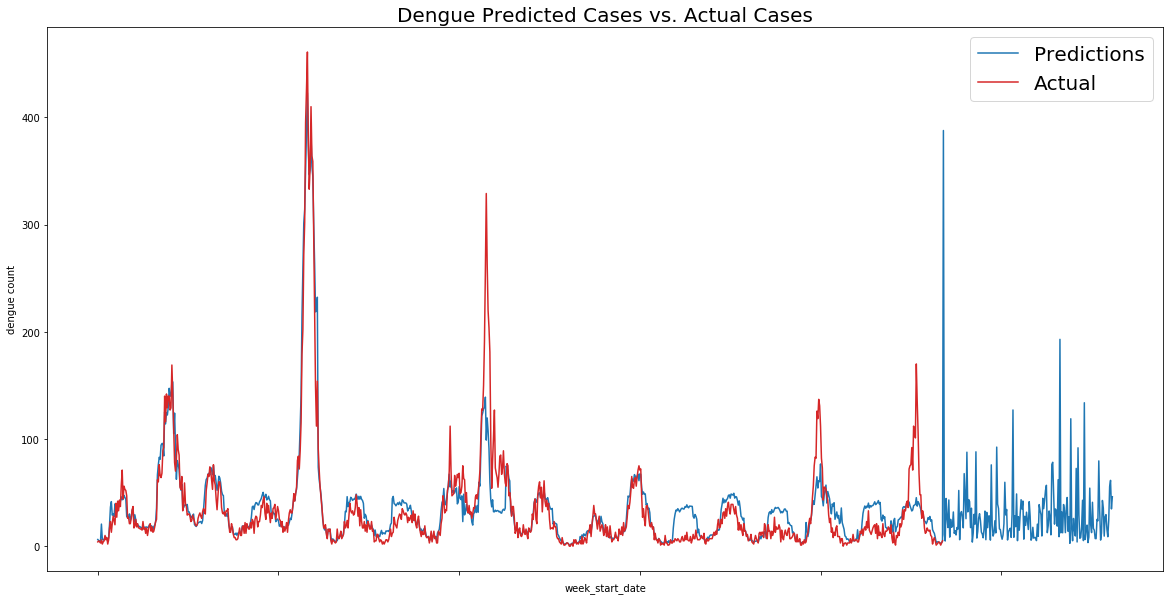

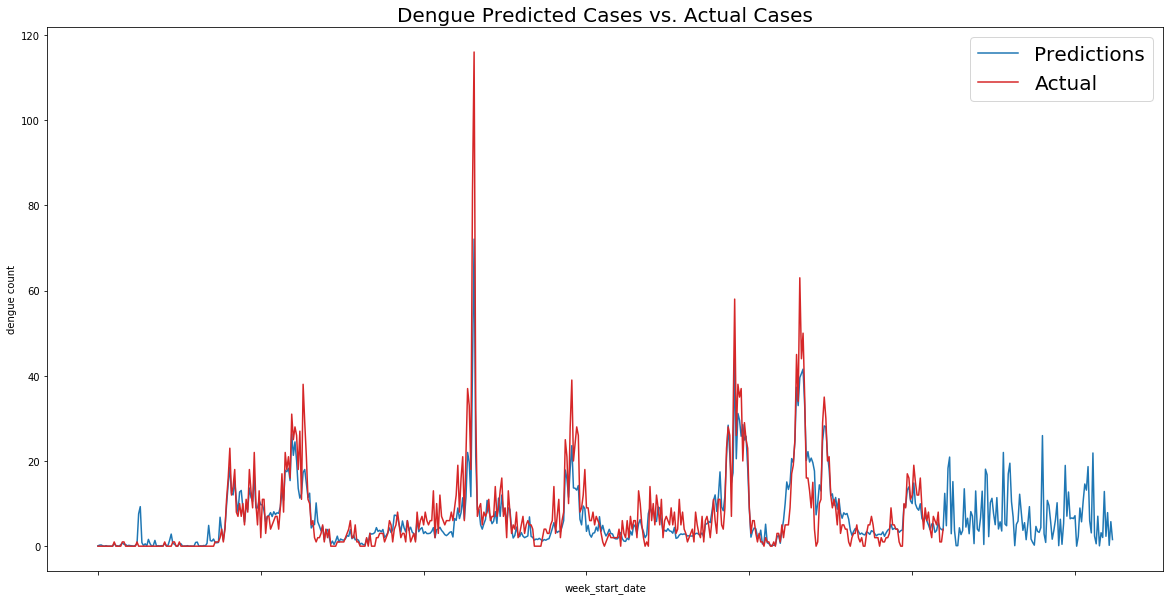

In [1060]:
plot_preds_actual_time(sj_rf_train_preds, sj_rf_test_preds, sj_train_features.total_cases)
plot_preds_actual_time(iq_rf_train_preds, iq_rf_test_preds, iq_train_features.total_cases)

Random forest performed the second best for us out of the four algorithms averaging at around 23.5 and 26 in our submissions at the time of writing. The plots seem to be much more reasonable, following a trend where there are peaks and lows.

#### Gradient Boost Pedcitions for SJ and IQ

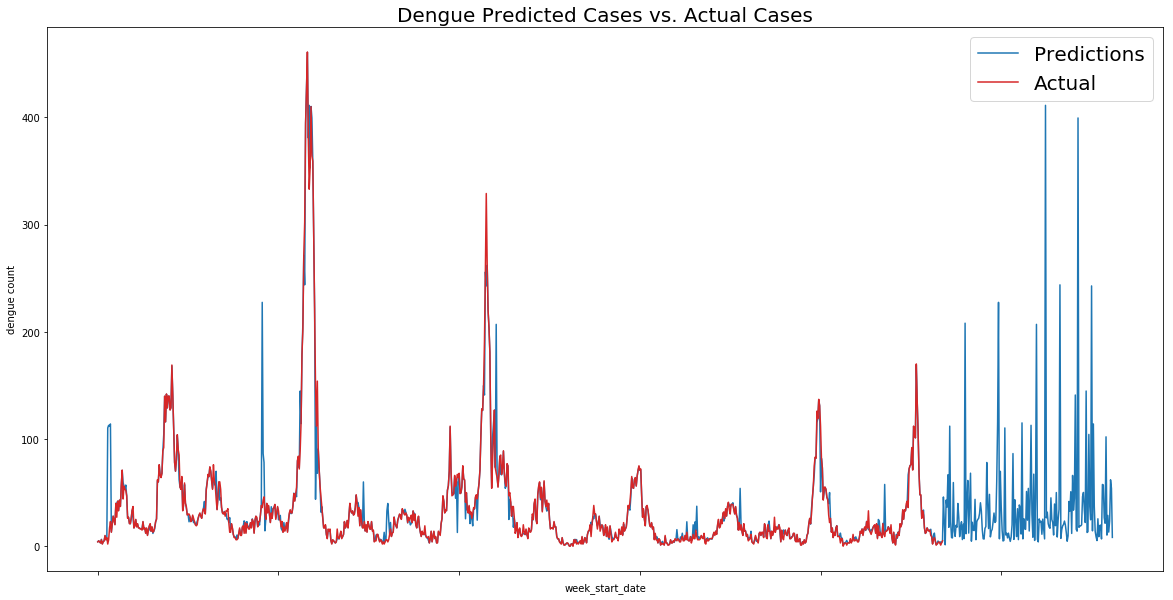

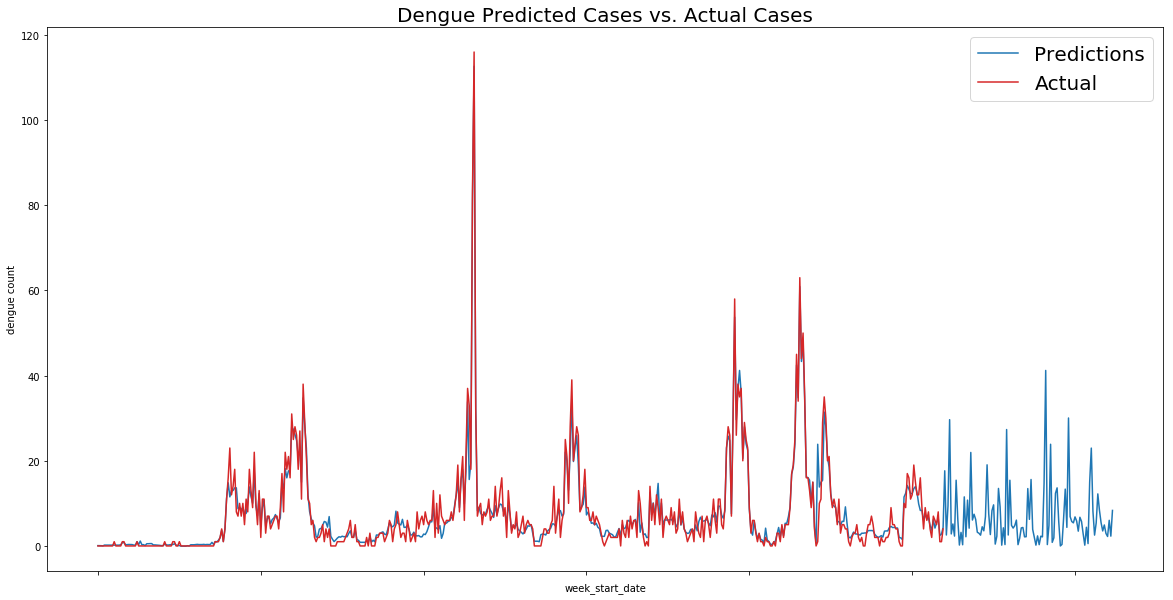

In [148]:
plot_preds_actual_time(sj_gb_train_preds, sj_gb_test_preds, sj_train_features.total_cases)
plot_preds_actual_time(iq_gb_train_preds, iq_gb_test_preds, iq_train_features.total_cases)

Gradient boost at the moment of writing seemed to perform the best. As with the other models we see a clear pattern of overfitting (due to our lack of expertise and ability for tuning ML algorithms). We see that it does not overfit to Iquitos as much but the amount of error is very different. It also ends up looking very noisy, we may try to resubmit with normalized values of the features. The best score we got at the time of writing is 23.19 from this model. 

#### SVM for SJ and IQ

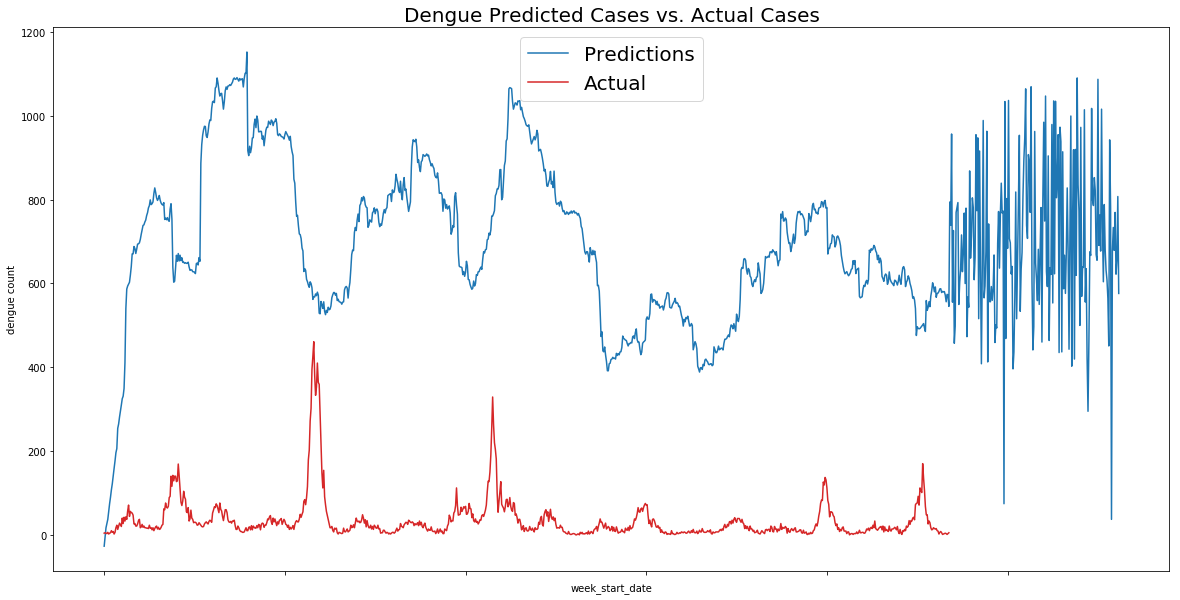

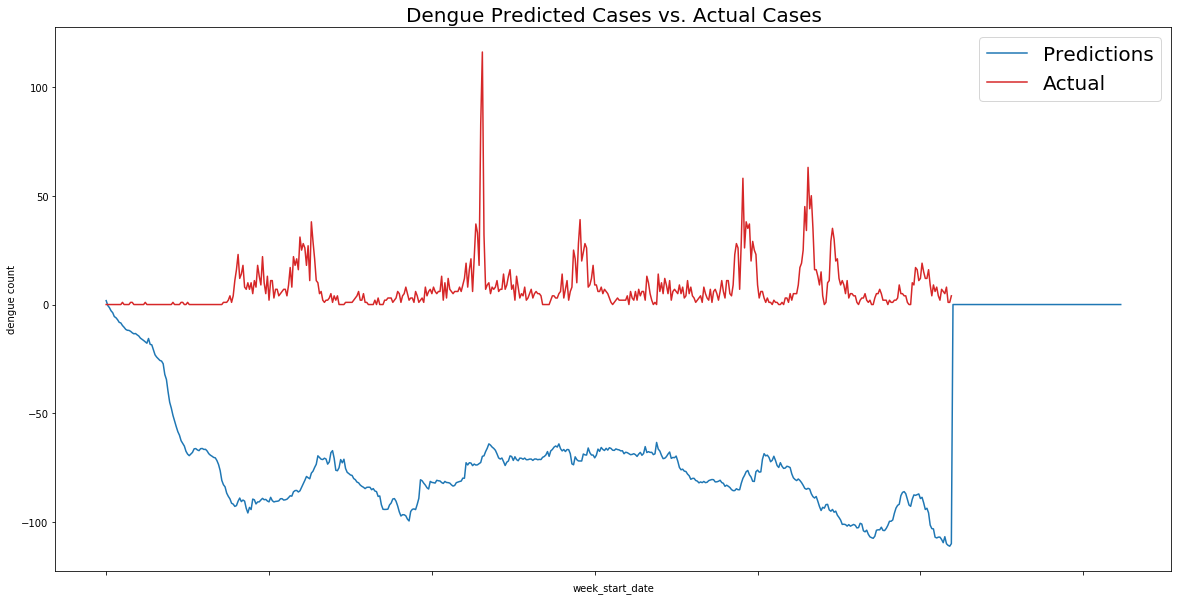

In [677]:
plot_preds_actual_time(sj_sv_train_preds, sj_sv_test_preds, sj_train_features.total_cases)
plot_preds_actual_time(iq_sv_train_preds, iq_sv_test_preds, iq_train_features.total_cases)

As shown by the time series analysis of our data, all of our predictions were overfitting the data except the SVR model. We were not sure why the SVR model ended up acting strangely. It is probably true that for predicting this case, SVR is not the best choice. When we clipped the value it eneded up all being 0 for Iquitos (because all predicted values were negative). We ended up with large underpredicted values in the Iquitos predictions and large overpredictions in San Juan. We decided to include the algorithms because we found a research paper that attempted the use for predicting [dengue cases in China](https://www.ncbi.nlm.nih.gov/pubmed/29036169). It showed extremley promising results where it consistently performed better than the other models used in the paper. We may ended up choosing the wrong parameters in our predictions.

Most of our plots seem to predict fairly well except the SVM model. All catch that there is a possible outbreak in Iquitos at around 2010. We believe overfitting is happening because we have chosen MAE as our metric of scoring in choosing the models. Improvements can be made.

### Scatter Plots of Train Predicted vs Actual Total Cases

To asses our models' predictions against the actual values, we created scatterplots. These plots reflect largely what we see when analyzing the MAE and the time-trends. XGBoost, Random Forest, Gradient Boost all performed generally well, with most the actual and prediction near to each other. SVM showed unpredictable trends, and was also affected by the zero-ing out of many negative values for Iquitos. There seems to be a trend of over/under predicting at clusters of low-level case totals, likely because of the over-representation of those numbers.

XGBoost scatter plot


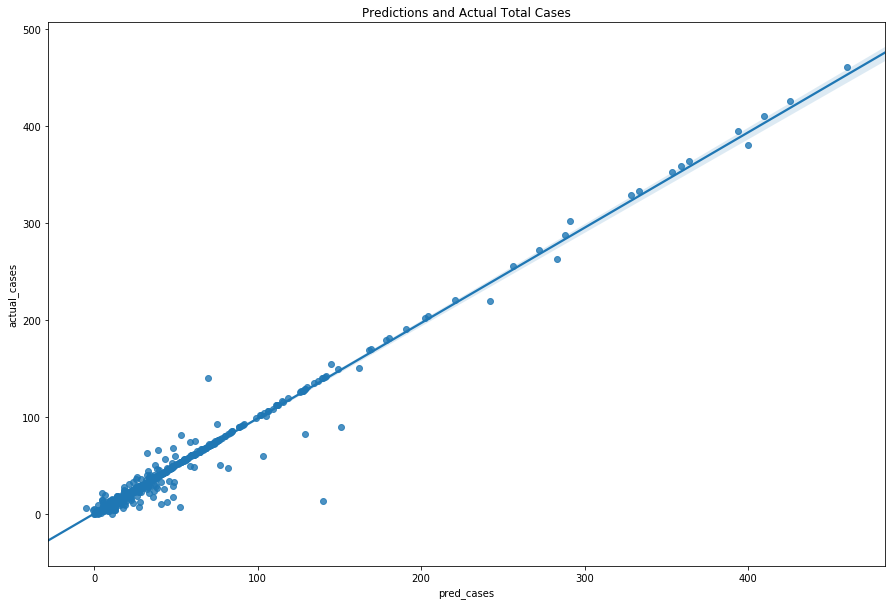

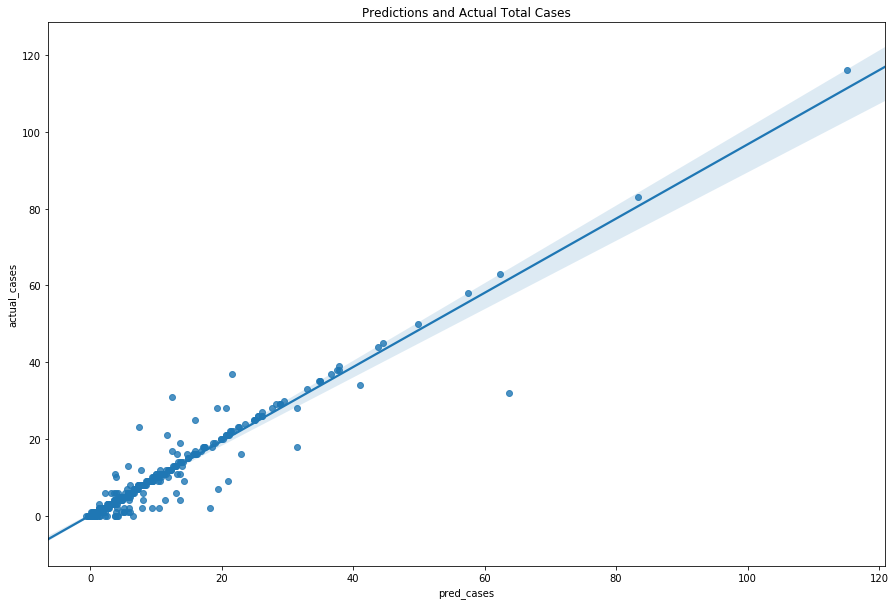

In [1110]:
# XGBoost plot
print('XGBoost scatter plot')
plot_preds_actual_scatter(sj_xgb_train_preds, sj_train_total_cases)
plot_preds_actual_scatter(iq_xgb_train_preds, iq_train_total_cases)

Random Forest scatter plot


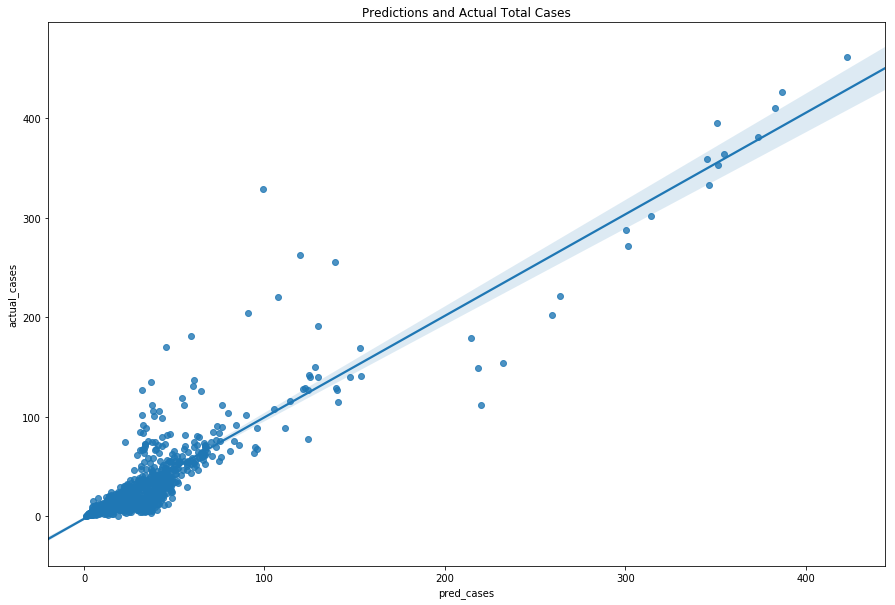

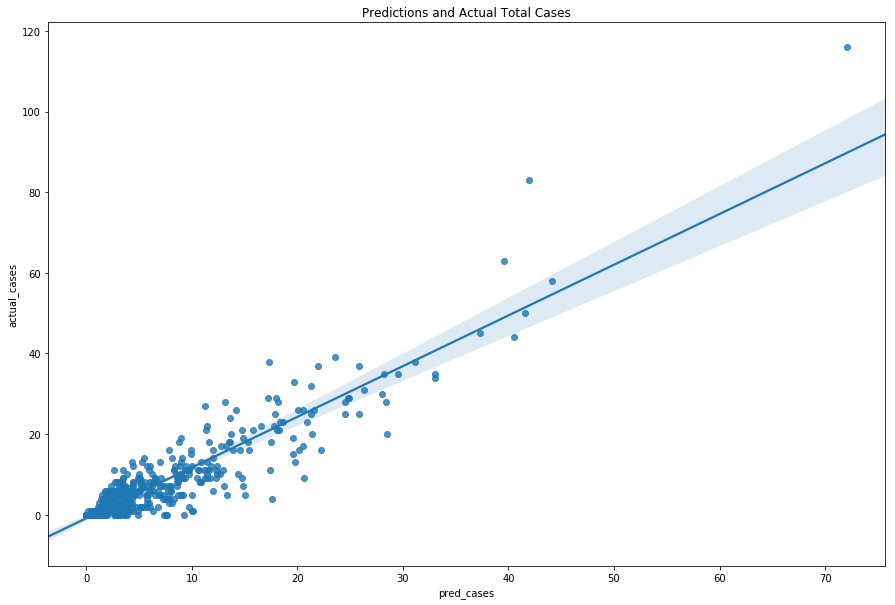

In [1111]:
# Random Forest plot
print('Random Forest scatter plot')
plot_preds_actual_scatter(sj_rf_train_preds, sj_train_total_cases)
plot_preds_actual_scatter(iq_rf_train_preds, iq_train_total_cases)

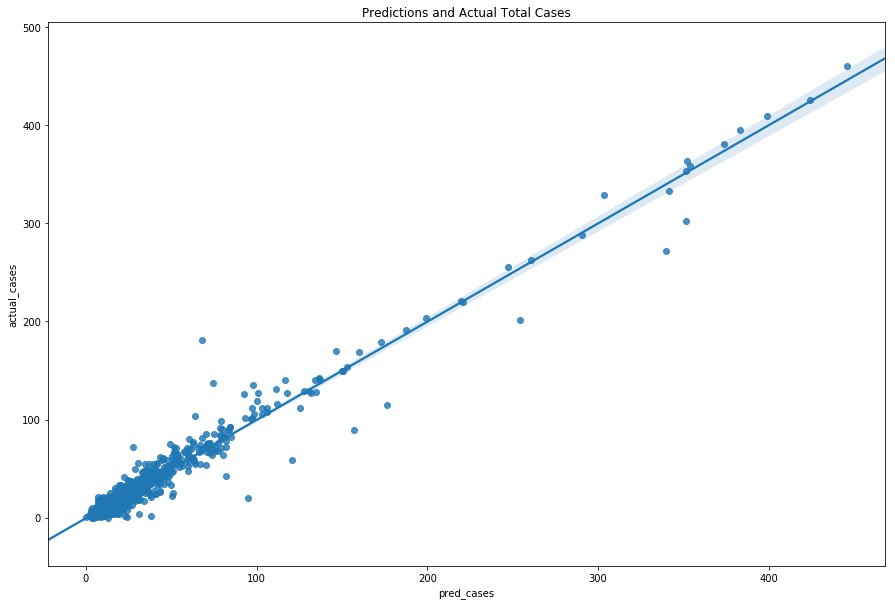

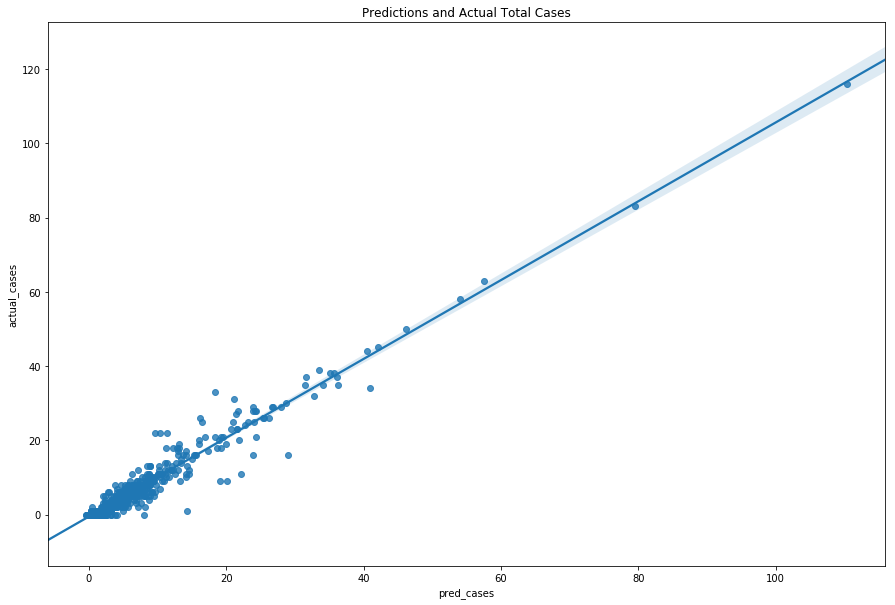

In [1112]:
# Gradient Boost plot
plot_preds_actual_scatter(sj_gb_train_preds, sj_train_total_cases)
plot_preds_actual_scatter(iq_gb_train_preds, iq_train_total_cases)

SVM scatter plot


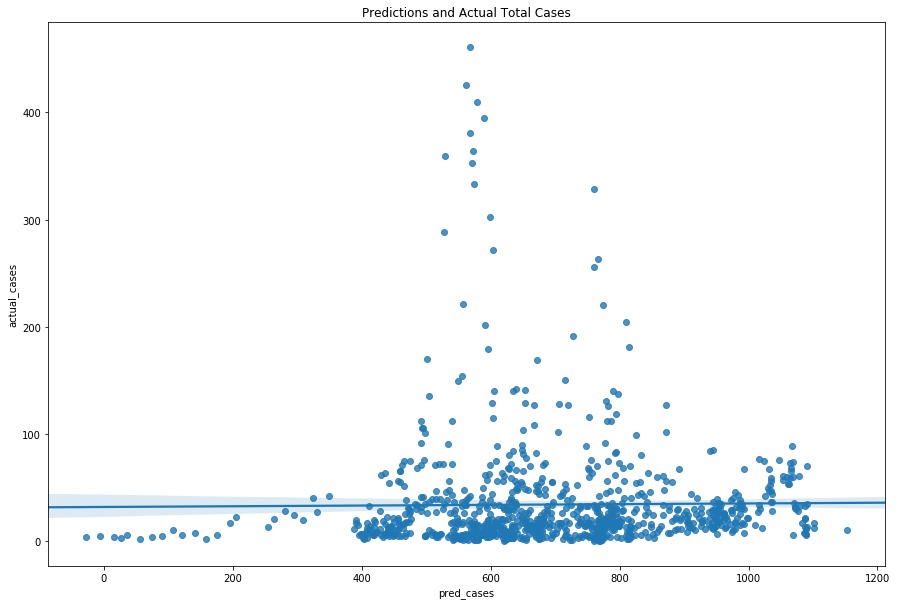

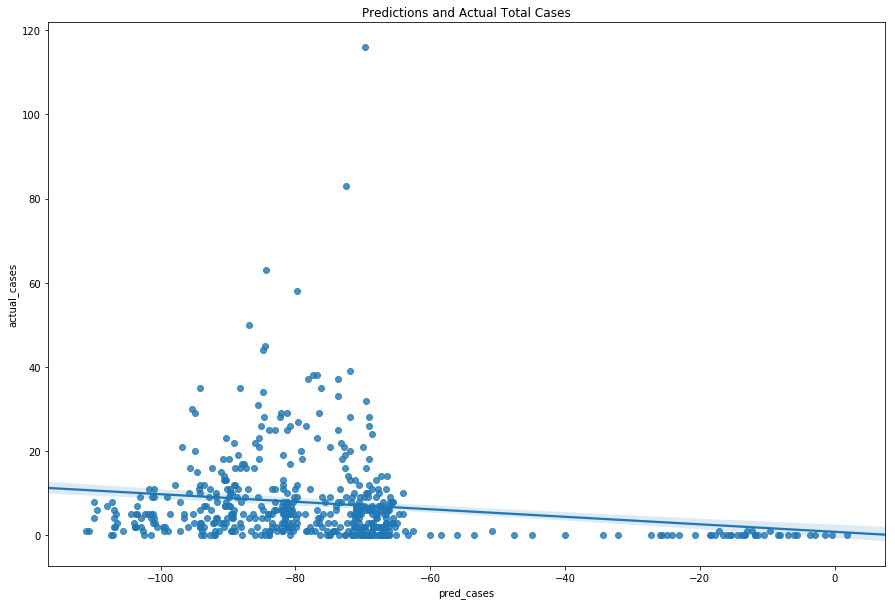

In [1113]:
# SVM plot
print('SVM scatter plot')
plot_preds_actual_scatter(sj_sv_train_preds, sj_train_total_cases)
plot_preds_actual_scatter(iq_sv_train_preds, iq_train_total_cases)

### Residual Plots

Our XGBoost model seems to similarly over and under-predict, with a tendency to under predict at higher counts of total cases.

The Random Forest model shows a similar pattern of over and under-prediction at low levels of case counts. However, this model also shows more over-prediction at higher case counts.

Our Gradient Boost model follows a similar pattern to the XGBoost model, most closely for Iquitos in the areas of higher case count under-predictions.

Again, our SVM model proves to be a bit uninterpretable and was likely not a good a model fit for this structure of data.

XGBoost residuals plot


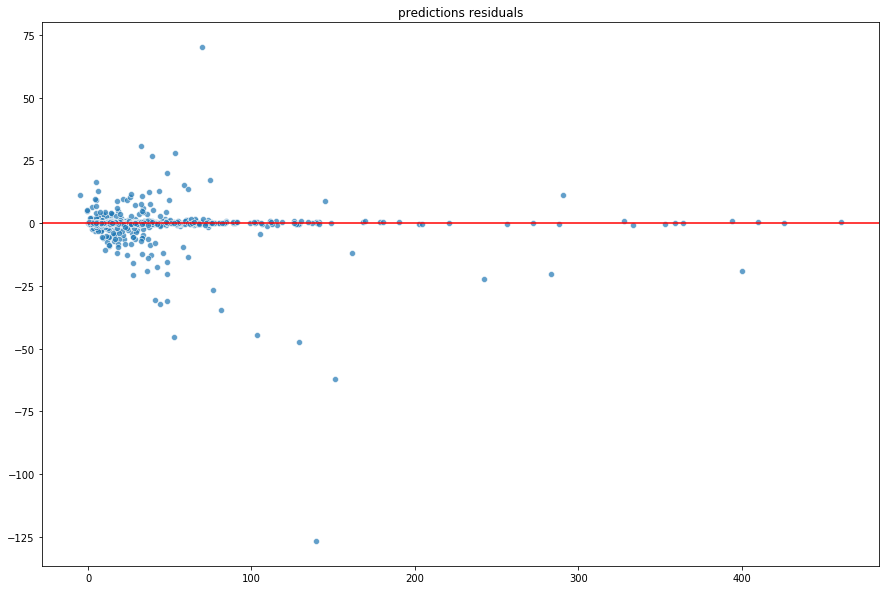

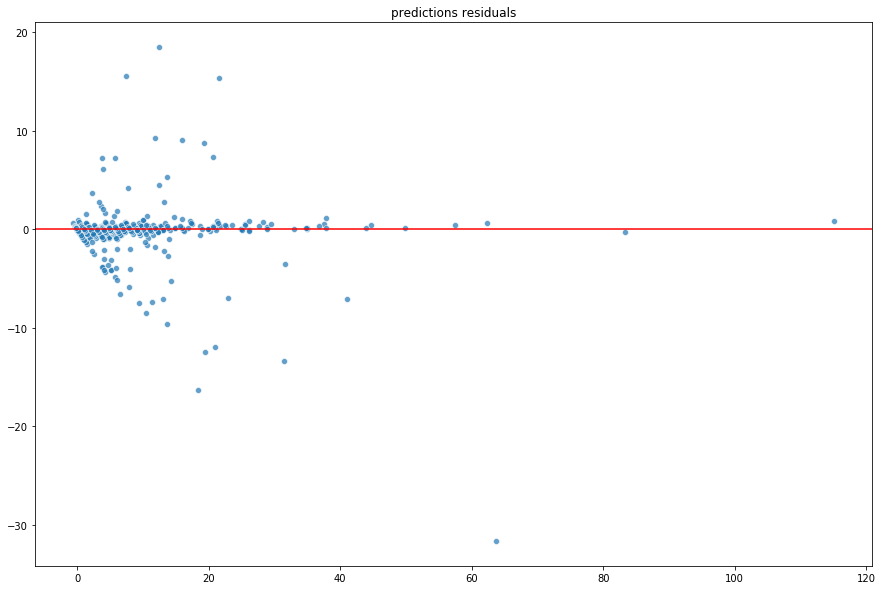

In [898]:
# XGB residuals plot
print('XGBoost residuals plot')
plot_preds_actual_residuals(sj_xgb_train_preds, sj_train_total_cases)
plot_preds_actual_residuals(iq_xgb_train_preds, iq_train_total_cases)

Random Forest residuals plot


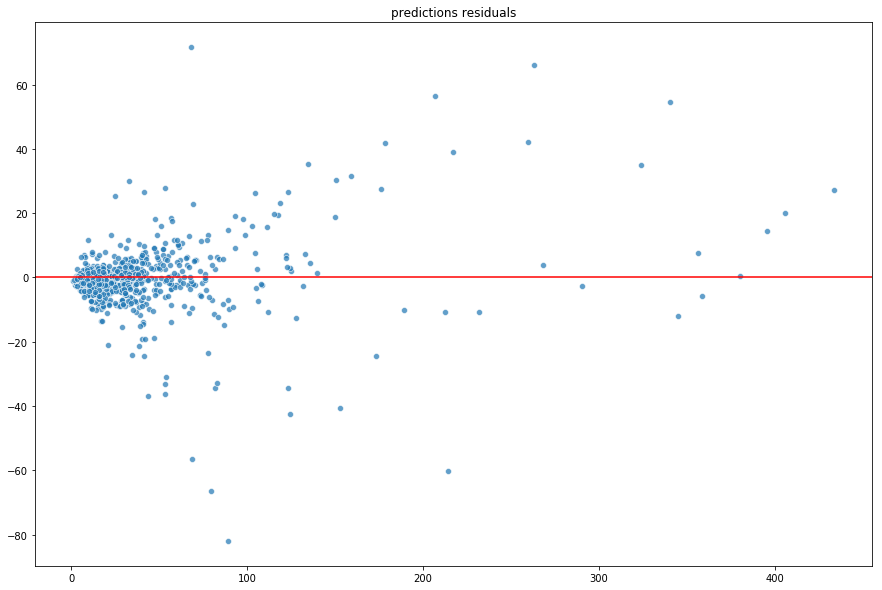

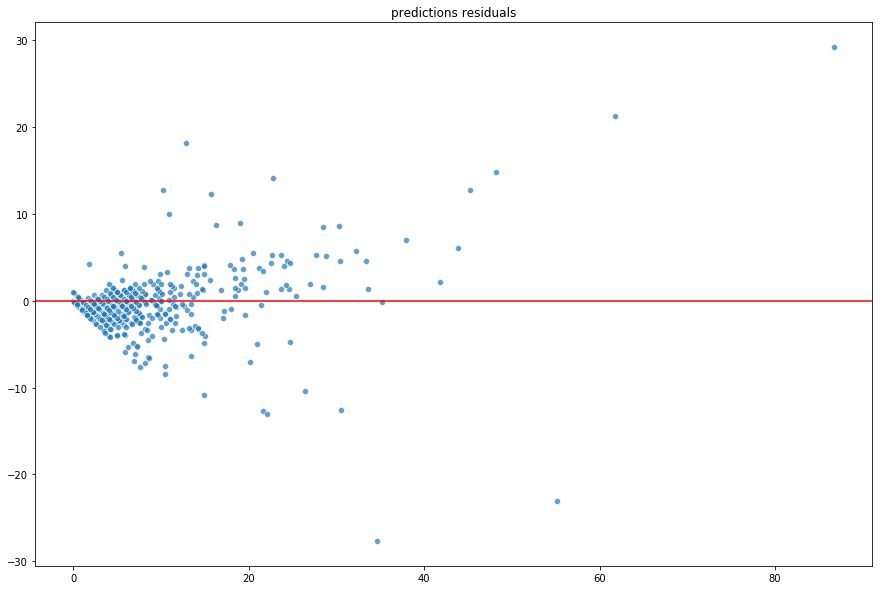

In [899]:
# RF residualsplot
print('Random Forest residuals plot')
plot_preds_actual_residuals(sj_rf_train_preds, sj_train_total_cases)
plot_preds_actual_residuals(iq_rf_train_preds, iq_train_total_cases)

Gradient Boost residuals plot


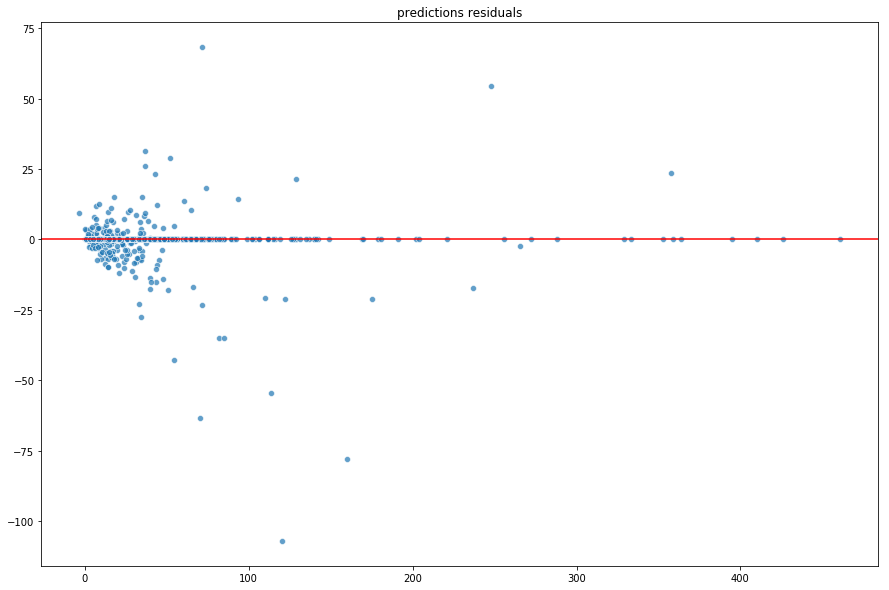

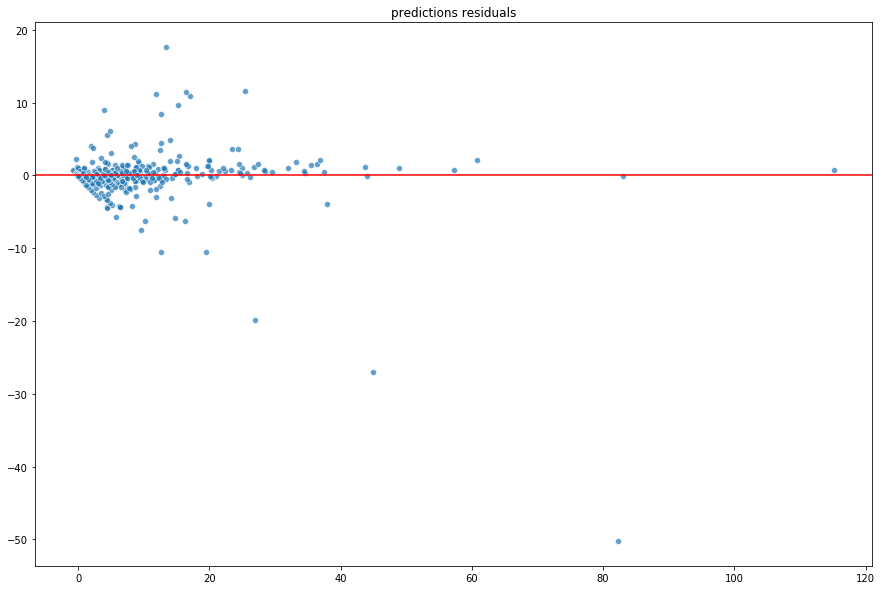

In [900]:
# GB residualsplot
print('Gradient Boost residuals plot')
plot_preds_actual_residuals(sj_gb_train_preds, sj_train_total_cases)
plot_preds_actual_residuals(iq_gb_train_preds, iq_train_total_cases)

SVR residuals plot


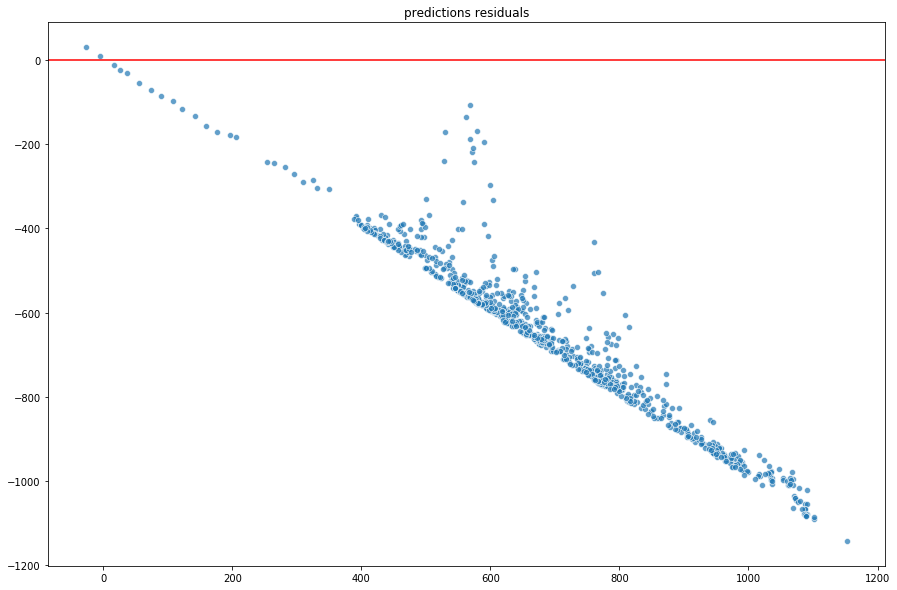

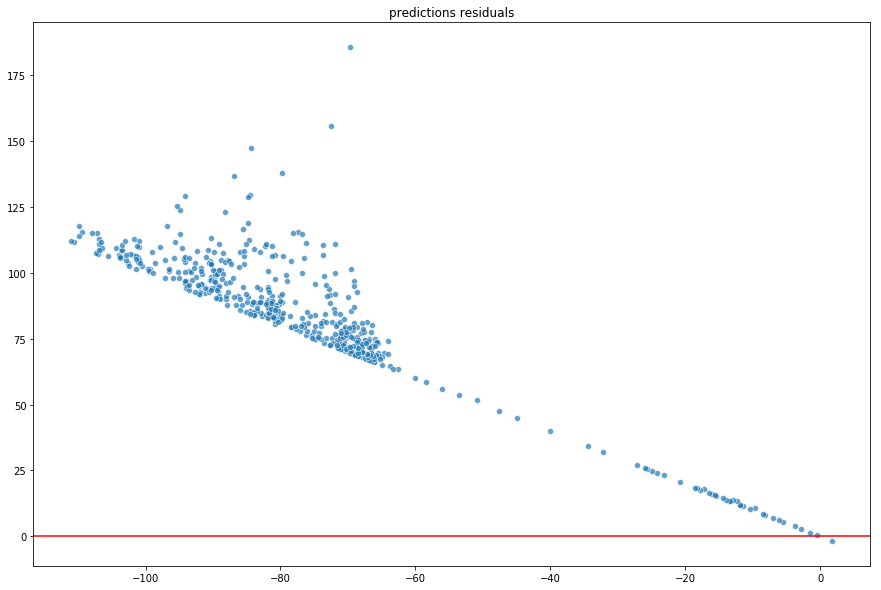

In [901]:
# SVR residualsplot
print('SVR residuals plot')
plot_preds_actual_residuals(sj_sv_train_preds, sj_train_total_cases)
plot_preds_actual_residuals(iq_sv_train_preds, iq_train_total_cases)

Best MAE: Gradient Boost 23.1923